# Exploração de modelos para a previsão de Cancro do Pulmão com base em TAC's



# Introdução e objetivos
O primeiro projecto desta unidade curricular, Laboratórios de IA e CD, consiste em usar imagens como dados de input, mais especificamente de Tomografias Computorizadas (TACs), do tronco humano, de modo a fazer uma classificação quanto à presença ou não de cancro do pulmão no paciente.

O objetivo desta unidade curricular(Lab IA & CD), assim como deste trabalho, é aprofundar os nossos conhecimentos na área da IA e CD, assim como fomentar as nossas capacidades de comunicação, de trabalho em equipa e de desenvolvimento de software.

## Bibliotecas utilizadas

A maioria das bibliotecas utilizadas já são nossas conhecidas de outras UCs, mas decidimos destacar a utilização da biblioteca "radiomics", pois foi a primeira vez que a utilizámos, tendo sido utilizada na obtenção das features através das imagens.


In [290]:
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
import pylidc as pl
from pylidc.utils import consensus
import SimpleITK as sitk
import six
from radiomics import featureextractor
import pandas as pd
import statistics

Utilizámos como label as anotações dos radiologistas, por isso, vamos apenas usar as imagens dos pacientes que têm essas anotações. 

O primeiro passo foi extrair as informações das imagens usando a biblioteca radiomics. A cada conjunto de caracteristicas vamos atribuir o id do paciente correspondente e o nódulo em questão, de modo a deixar o paciente certo com o conjunto de caracteristicas e nódulo correspondente. 

In [291]:
# Configure the PyRadiomics feature extractor
params = {
    'binWidth': 25,  # Adjust parameters as needed
    'resampledPixelSpacing': [1, 1, 1],  # Adjust spacing as needed
    'featureClass': ['firstorder', 'shape', 'glcm', 'glrlm', 'glszm', 'ngtdm', 'gldm','glcmms','gldzm','ngtdmms','glrmms','glszmms']  # Include feature classes
}

extractor = featureextractor.RadiomicsFeatureExtractor(**params)

# Consult all scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store features and patient IDs
features_list = []
patient_ids = []

# Variable to create unique IDs for nodules
nodule_id_counter = 1

# Iterate through all scans with annotations
for scan in scans_with_annotations:
    # Get the ID of the patient
    patient_id = scan.patient_id
    
    # Clusterize the annotations for the scan and retrieve all nodules
    nods = scan.cluster_annotations()
    
    # Iterate through all nodules of the patient
    for anns in nods:
        # Perform consensus clustering with a 50% agreement level
        cmask, cbbox, masks = consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])
        
        
        # Convert the pixel array to a SimpleITK image
        image = sitk.GetImageFromArray(cmask.astype(float))
        
        # Extract radiomic features using PyRadiomics
        features = extractor.execute(image, image, label=1)  # Use label 1 for the nodule
        
        # Add the patient ID to the list
        patient_ids.append(patient_id)
        
        # Add a unique ID for the nodule
        features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
        nodule_id_counter += 1
        
        # Add the features to the list
        features_list.append(features)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)

# Add a column "Patient_ID" to the DataFrame
features_df['Patient_ID'] = patient_ids

# Save the selected features to a CSV file
features_df.to_csv('features.csv', index=False)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

KeyboardInterrupt: 

In [ ]:
max=9999999
contador=0
for scan in scans_with_annotations:
    # Get the ID of the patient
    patient_id = scan.patient_id
    
    # Clusterize the annotations for the scan and retrieve all nodules
    nods = scan.cluster_annotations()
    
    # Iterate through all nodules of the patient
    for anns in nods:
        for ann in anns:
            contador+=1
        if contador<max:
            max=contador
        contador=0
print(max)

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

o passo seguinte foi a criação de outro df com as anotações para cada par nodulo-paciente;

Para a label (malignancy) usamos uma média pesada, com pesos maiores no 1 e no 5 devido ao facto de a mesma indicar precisamente se o nódulo é maligno ou não.

Para os restantes usamos o valor mais comum e quando não existe valor mais comum usamos a média normal. 

In [ ]:
# Variable to create unique IDs for nodules
nodule_id_counter = 1
data = []

# Iterate through all scans with annotations
for scan in scans_with_annotations:
    # Get the ID of the patient
    patient_id = scan.patient_id
    
    # Clusterize the annotations for the scan and retrieve all nodules
    nods = scan.cluster_annotations()
    
    # Iterate through all nodules of the patient
    for anns in nods:
        # Calculate the weighted average for "malignancy" with different weights
        malignancy_values = [ann.malignancy for ann in anns]
        weighted_sum = sum(1.25*value if value == 5 else (0.75*value if value == 1 else value) for value in malignancy_values)
        total_weight = sum(1.25 if value == 5 else (0.75 if value == 1 else 1) for value in malignancy_values)
        mean_malignancy = weighted_sum / total_weight if total_weight > 0 else 0

        # Calculate the mode (most common value) for other features
        def calculate_mode(values):
            try:
                return statistics.mode(values)
            except statistics.StatisticsError:
                return np.mean(values)
        
        mode_subtely=calculate_mode([ann.subtlety for ann in anns])
        mode_internalStructure = calculate_mode([ann.internalStructure for ann in anns])
        mode_calcification = calculate_mode([ann.calcification for ann in anns])
        mode_sphericity = calculate_mode([ann.sphericity for ann in anns])
        mode_margin = calculate_mode([ann.margin for ann in anns])
        mode_lobulation = calculate_mode([ann.lobulation for ann in anns])
        mode_spiculation = calculate_mode([ann.spiculation for ann in anns])
        mode_texture = calculate_mode([ann.texture for ann in anns])
        

        # Create a dictionary to store the data
        row = {
            'Patient_ID': patient_id,
            'Nodule_ID': f'Nodule_{nodule_id_counter}',
            'subtlety': mode_subtely,
            'internalStructure': mode_internalStructure,
            'calcification': mode_calcification,
            'sphericity': mode_sphericity,
            'margin': mode_margin,
            'lobulation': mode_lobulation,
            'spiculation': mode_spiculation,
            'texture': mode_texture,
            'malignancy': mean_malignancy
        }
        
        data.append(row)
        nodule_id_counter += 1

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('annotations.csv', index=False)


Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

## Tratamento de Dados
#### Bibliotecas utilizadas


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

Ler as tabelas e criar os valores da label com base na malignancy, isto é, 0 se a malignancy for <= 3, 1 em caso contrário.

Esta label indica se o nódulo do paciente em questão é cancerígeno ou não.

In [ ]:
features = pd.read_csv('features.csv')
annot=pd.read_csv('annotations.csv')

In [ ]:
values=[]
count1=0
count0=0
for value in annot['malignancy']:
    if value>3:
        values.append(1)
        count1+=1
    else:
        values.append(0)
        count0+=1
y = values  
print(f'Label1: {count1} Label0: {count0}')

Label1: 670 Label0: 1981


É notório o grande desiquilibrio verificado nesta fase entre as classes, o que poderá afetar o modelo. 

Decidimos continuar o trabalho sem efetuar qualquer tipo de alteração nesta questão, apesar de haverem métodos possiveis para o fazer, como Data Augmentation/Reduction e de acreditarmos que se o fizéssemos teríamos melhores resultados.

Aqui podemos visualizar todas as colunas.

In [ ]:
for column in features.columns:
    print(column)

diagnostics_Versions_PyRadiomics
diagnostics_Versions_Numpy
diagnostics_Versions_SimpleITK
diagnostics_Versions_PyWavelet
diagnostics_Versions_Python
diagnostics_Configuration_Settings
diagnostics_Configuration_EnabledImageTypes
diagnostics_Image-original_Hash
diagnostics_Image-original_Dimensionality
diagnostics_Image-original_Spacing
diagnostics_Image-original_Size
diagnostics_Image-original_Mean
diagnostics_Image-original_Minimum
diagnostics_Image-original_Maximum
diagnostics_Mask-original_Hash
diagnostics_Mask-original_Spacing
diagnostics_Mask-original_Size
diagnostics_Mask-original_BoundingBox
diagnostics_Mask-original_VoxelNum
diagnostics_Mask-original_VolumeNum
diagnostics_Mask-original_CenterOfMassIndex
diagnostics_Mask-original_CenterOfMass
diagnostics_Image-interpolated_Spacing
diagnostics_Image-interpolated_Size
diagnostics_Image-interpolated_Mean
diagnostics_Image-interpolated_Minimum
diagnostics_Image-interpolated_Maximum
diagnostics_Mask-interpolated_Spacing
diagnostics_M

Todas as colunas que mencionam "diagnostics" são referentes a variáveis de versões e de caracteristicas que são irrelevantes para o modelo, logo podemos eliminar.

Isto deve-se ao facto de as features que decidimos manter estarem nomeadas com "orginal_ngtdm_(nome da feature)". 

In [ ]:
feat = features.iloc[:,37:-2] 
for column in feat.columns:
    print(column)

original_shape_Elongation
original_shape_Flatness
original_shape_LeastAxisLength
original_shape_MajorAxisLength
original_shape_Maximum2DDiameterColumn
original_shape_Maximum2DDiameterRow
original_shape_Maximum2DDiameterSlice
original_shape_Maximum3DDiameter
original_shape_MeshVolume
original_shape_MinorAxisLength
original_shape_Sphericity
original_shape_SurfaceArea
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume
original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_Maximum
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_Minimum
original_firstorder_Range
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
o

In [ ]:
# Tabela final com dados
InputData=pd.concat([annot,feat],axis=1)
InputData.to_csv('complete_data.csv',index=False)
index=InputData.iloc[:,0:2]
X = InputData.drop(InputData.columns[[0,1]],axis=1)
X.drop(['malignancy'],axis=1,inplace=True)

Decidimos fazer um StandardCaler de modo a por todas as varíaveis na mesma escala, e efetuamos a divisão do dataset em 70% training set e 30% test set.

In [ ]:
scaler = StandardScaler()

X_continuous = scaler.fit_transform(X)

scaled = pd.DataFrame(X_continuous, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.3)

# Criação dos modelos e resultados iniciais
# Implementação do primeiro modelo - Random Forest

O primeiro modelo que decidimos criar foi um Random Forest. 

Tomamos esta decisão pois sabemos que o mesmo é capaz de lidar com a grande dimensionalidade dos dados e iterar nos parametros para obter um possível melhor resultado nestas condições.

Optamos também por utilizar uma função GridSearchCV, que efetua cross-validation, o que permite treinar o modelo com conjuntos de treino diferentes.

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\zezam\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zezam\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zezam\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\zezam\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\zezam\anaconda3\lib\site-packages

RandomForestClassifier(max_depth=10)
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       574
           1       0.77      0.68      0.72       222

    accuracy                           0.85       796
   macro avg       0.82      0.80      0.81       796
weighted avg       0.85      0.85      0.85       796

Accuracy: 0.8530150753768844
Precision: 0.7692307692307693
Recall: 0.6756756756756757


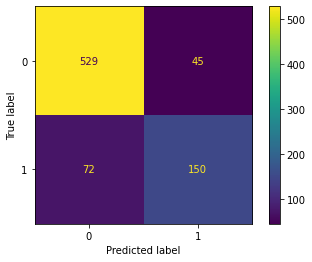

In [ ]:
param_grid={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }


grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=1);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))


cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, grid_predictions)
precision = precision_score(y_test, grid_predictions)
recall = recall_score(y_test, grid_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)



In [ ]:
print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Fazendo uma análise preliminar dos resultados, podemos verificar que a accuracy está intermédia, assim como o recall.

Acreditamos que equilibrar as classes pode ser uma possível solução para obter uma melhor accuracy, algo que será abordado mais à frente no trabalho.

## Implementação do segundo modelo - SVM

Optámos por implementar uma SVM (support vector machine), devido à sua particular eficiência em problemas de classificação como o do trabalho proposto.

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=100, gamma=0.001)
              precision    recall  f1-score   support

           0       0.88      0.96      0.91       574
           1       0.85      0.65      0.74       222

    accuracy                           0.87       796
   macro avg       0.86      0.80      0.83       796
weighted avg       0.87      0.87      0.86       796



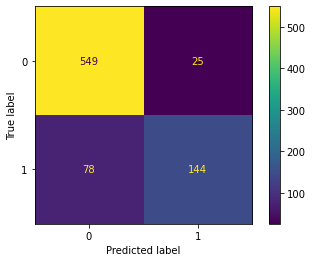

In [ ]:
melhor=0

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))


cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

O modelo SVM apresenta uma ligeira melhoria em termos de accuracy quando comparado ao random forrest implementado anteriormente. Isto deve-se ao facto de apresentar menos falsos positivos.

# Implementação do terceiro modelo - KNN

Decidimos implementar o KNN pois é para nós um modelo já muito conhecido e de fácil implementação, por isso também a titulo de curiosidade decidimos comparar o seu desempenho com os restantes modelos implementados.

Acurácia: 0.8706030150753769
Precision: 0.8361581920903954
Recall: 0.6666666666666666
43


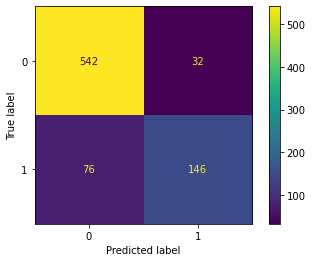

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

melhor=0

for k in range(1,100):
    # Você pode ajustar esse valor
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Treine o classificador com os dados de treinamento
    knn_classifier.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    y_pred = knn_classifier.predict(X_test)

    # Calcule a precisão das previsões
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    if accuracy>melhor:
        melhork=k
        melhor=accuracy
        melhorp=precision
        melhorr=recall
print(f"Acurácia: {melhor}")
print("Precision:", melhorp)
print("Recall:", melhorr)
print(melhork)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

O resultado obtido não foi surpreendente, sendo muito parecido com o do random forest.

Ainda assim, optámos por implementar um último modelo para ver se haveria alguma mudança na previsão.  

# Implementação do quarto modelo - Rede neuronal

### Por ultimo criamos uma NN a iterar em vários parametros e a devolver o melhor modelo possivel.

### Decidimos usar uma NN porque achamos que os dados são bastante complexos e se torna bastante dificil para um dos outros algoritmos detetar esses padrões.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Suponha que você tenha um DataFrame 'X_train' com suas features e uma Serie 'y_train' com os rótulos/targets
# Convertemos X_train e y_train para arrays NumPy


X_NN = X_train.values.tolist()
y_NN = y_train


# Defina listas de parâmetros a serem testados
hidden_layer_sizes = [64, 128, 256]
epochs_list = [50, 100]
learnRate = [0.01,0.1,0.5]

best_accuracy = 0
best_model = None
best_loss = None

# Listas para armazenar accuracy e loss
accuracies = []
losses = []

# Itere sobre as diferentes combinações de parâmetros
for hidden_layers in hidden_layer_sizes:
    for epochs in epochs_list:
        for learningRate in learnRate:
                # Crie o modelo
            model = Sequential()
            for i in range(2):
                model.add(Dense(hidden_layers, activation='relu', input_shape=(X_train.shape[1],)))
                
            model.add(Dense(1, activation='softmax'))  # Camada de output

            # Compile o modelo
            model.compile(loss='binary_crossentropy', optimizer=Adam(learningRate), metrics=['accuracy'])

            # Treine o modelo
            history = model.fit(X_NN, y_NN, epochs=epochs, verbose=0)  # Use verbose=0 para evitar logs durante o treinamento

            # Avalie o modelo
            loss, accuracy = model.evaluate(X_test.values.tolist(), y_test, verbose=0)

            # Armazene accuracy e loss
            accuracies.append(accuracy)
            losses.append(loss)
        
            # Verifique se este é o melhor modelo até agora
            if accuracy > best_accuracy:
                best_hidden_layer_sizes =hidden_layers
                best_epochs_list = epochs
                best_accuracy = accuracy
                best_model = model
                best_loss = loss

# O melhor modelo é armazenado em 'best_model'
print(f"Melhor Acurácia encontrada: {best_accuracy:.2f}")
print(f"Loss do Melhor Modelo: {best_loss:.2f}")
print(f"melhor numero de camadas ocultas: {best_hidden_layer_sizes}")
print(f"Melhor numero de epochs: {best_epochs_list}")


Epoch 1/50
58/58 [==============================] - 1s 2ms/step - loss: 0.3919 - accuracy: 0.2518
Epoch 2/50
58/58 [==============================] - 0s 2ms/step - loss: 0.3311 - accuracy: 0.2518
Epoch 3/50
58/58 [==============================] - 0s 2ms/step - loss: 0.3229 - accuracy: 0.2518
Epoch 4/50
58/58 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.2518
Epoch 5/50
58/58 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.2518
Epoch 6/50
58/58 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.2518
Epoch 7/50
58/58 [==============================] - 0s 2ms/step - loss: 0.2954 - accuracy: 0.2518
Epoch 8/50
58/58 [==============================] - 0s 2ms/step - loss: 0.2845 - accuracy: 0.2518
Epoch 9/50
58/58 [==============================] - 0s 2ms/step - loss: 0.2815 - accuracy: 0.2518
Epoch 10/50
58/58 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.2518
Epoch 11/50
58/58 [

KeyboardInterrupt: 

In [ ]:
loss, accuracy = best_model.evaluate(X_test.values.tolist(), y_test, verbose=0)      
print(loss)
print(accuracy)
print(best_model.summary())

In [ ]:
predictions = (model.predict(X_test.values.tolist()) > 0.5).astype(int)
from sklearn.metrics import classification_report
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred_bool))

# Alteração nos dados - Data augmentation e redution

Apesar do output da rede neuronal ter demonstrado claras melhorias em relação aos modelos anteriores, decidimos ainda equilibrar o número de labels, quer por aumentação quer por diminuição.

Para o fazer, utilizamos a biblioteca "imblearn".

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Suponha que 'dados' seja o DataFrame com seus dados e 'labels' seja a coluna de labels.
# Suponha que 'scaled' seja seu DataFrame já dimensionado.

# Separe a população sem câncer
populacao_sem_cancer = []

for i in range(len(values)):
    if values[i] == 0:
        populacao_sem_cancer.append(i)

# Crie um DataFrame para rastrear os outliers em relação a cada variável
outliers_df = pd.DataFrame(index=X.index)

# Itere sobre cada coluna do DataFrame 'scaled'
for coluna in X.columns:
    data_plot1 = X[X.index.isin(populacao_sem_cancer)]
    data_plot = data_plot1[coluna]
    
    # Crie um gráfico de box plot para a variável
    plt.figure(figsize=(6, 4))
    data_plot.plot.box(vert=False)
    plt.title(f'Box Plot de Outliers em {coluna}')
    plt.xlabel('Valores')
    plt.show()

    # Identifique os outliers para a variável
    limite = 3  # Defina o limite de outlier como desejar
    z_scores = np.abs((data_plot - data_plot.mean()) / data_plot.std())
    outliers = z_scores > limite
    outliers_df[coluna] = outliers.astype(int)

print(outliers_df)

[2, 5, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 84, 85, 86, 88, 89, 91, 93, 95, 96, 97, 98, 99, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 123, 124, 125, 126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 157, 158, 160, 161, 162, 166, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 179, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 200, 203, 210, 211, 213, 214, 216, 217, 220, 230, 231, 232, 233, 235, 238, 239, 241, 246, 247, 248, 249, 250, 252, 255, 256, 257, 259, 260, 263, 265, 266, 267, 268, 270, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 307, 310, 312, 314, 315, 316, 317, 318, 31

C:\Users\Campião\AppData\Local\Temp\ipykernel_21396\2713992272.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)
C:\Users\Campião\AppData\Local\Temp\ipykernel_21396\2713992272.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)
C:\Users\Campião\AppData\Local\Temp\ipykernel_21396\2713992272.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

      subtlety  internalStructure  calcification  sphericity  margin  \
0          NaN                NaN            NaN         NaN     NaN   
1          NaN                NaN            NaN         NaN     NaN   
2          0.0                0.0            0.0         0.0     0.0   
3          NaN                NaN            NaN         NaN     NaN   
4          NaN                NaN            NaN         NaN     NaN   
...        ...                ...            ...         ...     ...   
2646       NaN                NaN            NaN         NaN     NaN   
2647       NaN                NaN            NaN         NaN     NaN   
2648       NaN                NaN            NaN         NaN     NaN   
2649       0.0                0.0            0.0         0.0     0.0   
2650       0.0                0.0            1.0         0.0     0.0   

      lobulation  spiculation  texture  original_shape_Elongation  \
0            NaN          NaN      NaN                        NaN 

C:\Users\Campião\AppData\Local\Temp\ipykernel_21396\2713992272.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)
C:\Users\Campião\AppData\Local\Temp\ipykernel_21396\2713992272.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers_df[coluna] = outliers.astype(int)
C:\Users\Campião\AppData\Local\Temp\ipykernel_21396\2713992272.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [ ]:
outliers_df['Total'] = outliers_df.sum(axis=1)

# Agora você tem a coluna 'Total' adicionada ao seu DataFrame com a soma de cada linha.

indicetirar=[]
outliers20=outliers_df['Total'].tolist()
for i in range(len(outliers20)):
    if outliers20[i]<=20:
        indicetirar.append(i)


X2=X.iloc[indicetirar]


# Use list comprehension para criar uma nova lista sem os valores nos índices especificados
y_alterado = [valor for i, valor in enumerate(values) if i in indicetirar]

[0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
oversample = SMOTE()
counter = Counter(y_alterado)
print(counter)

Counter({0: 1966, 1: 670})


In [ ]:
X2, y2 = oversample.fit_resample(X2, y_alterado)
print(Counter(y2))

Counter({1: 1966, 0: 1966})


In [ ]:
scaler = StandardScaler()

X_continuous = scaler.fit_transform(X2)

scaled = pd.DataFrame(X_continuous, columns=X2.columns)
X_train, X_test, y_train, y_test = train_test_split(scaled, y2, test_size=0.3)

Após efetuar novamente o Standard-Scalling, decidimos voltar a executar os três algoritmos com o novo conjunto de labels equilibradas.

In [ ]:
param_grid={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }


grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=1);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))


cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, grid_predictions)
precision = precision_score(y_test, grid_predictions)
recall = recall_score(y_test, grid_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, 

KeyboardInterrupt: 

In [ ]:
print(grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


SVC(C=1, gamma=0.1)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       596
           1       0.86      0.88      0.87       593

    accuracy                           0.87      1189
   macro avg       0.87      0.87      0.87      1189
weighted avg       0.87      0.87      0.87      1189



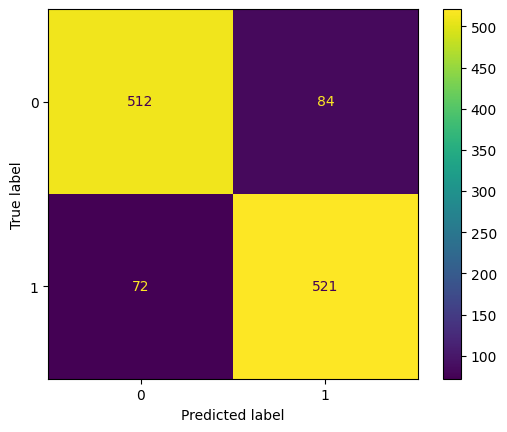

In [ ]:
melhor=0

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0);
grid.fit(X_train, y_train)
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))


cm = confusion_matrix(y_test, grid_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Acurácia: 0.864592094196804
Precision: 0.8506493506493507
Recall: 0.8836424957841484
8


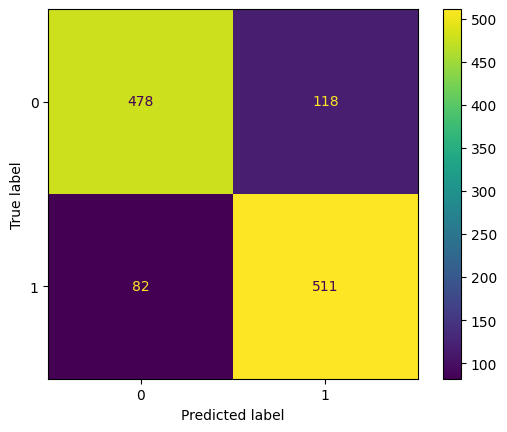

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

melhor=0

for k in range(1,100):
    # Você pode ajustar esse valor
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Treine o classificador com os dados de treinamento
    knn_classifier.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    y_pred = knn_classifier.predict(X_test)

    # Calcule a precisão das previsões
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    if accuracy>melhor:
        melhork=k
        melhor=accuracy
        melhorp=precision
        melhorr=recall
print(f"Acurácia: {melhor}")
print("Precision:", melhorp)
print("Recall:", melhorr)
print(melhork)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Suponha que você tenha um DataFrame 'X_train' com suas features e uma Serie 'y_train' com os rótulos/targets

# Convertemos X_train e y_train para arrays NumPy
X_NN = X_train.values.tolist()
y_NN = y_train

# Defina listas de parâmetros a serem testados
hidden_layer_sizes = [(12, 8), (10, 6), (8, 4)]
epochs_list = [100, 150, 200]
batch_size_list = [5, 10, 20]

best_accuracy = 0
best_model = None

# Listas para armazenar accuracy e loss
accuracies = []
losses = []

# Itere sobre as diferentes combinações de parâmetros
for hidden_layers in hidden_layer_sizes:
    for epochs in epochs_list:
        for batch_size in batch_size_list:
            # Crie o modelo
            model = Sequential()
            for units in hidden_layers:
                model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
            model.add(Dense(1, activation='sigmoid'))
            
            # Compile o modelo
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            
            # Treine o modelo
            history = model.fit(X_NN, y_NN, epochs=epochs, batch_size=batch_size, verbose=0)
            
            # Avalie o modelo
            loss, accuracy = model.evaluate(X_test.values.tolist(), y_test, verbose=0)
            
            # Armazene accuracy e loss
            accuracies.append(accuracy)
            losses.append(loss)
            
            # Verifique se este é o melhor modelo até agora
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
print('Melhor accuracy: ', best_accuracy)


KeyboardInterrupt: 

38/38 [==============================] - 0s 1ms/step
[[3.6310684e-02]
 [9.7882789e-01]
 [8.0281422e-02]
 ...
 [2.3186735e-06]
 [9.9999458e-01]
 [9.9515969e-01]]
[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0

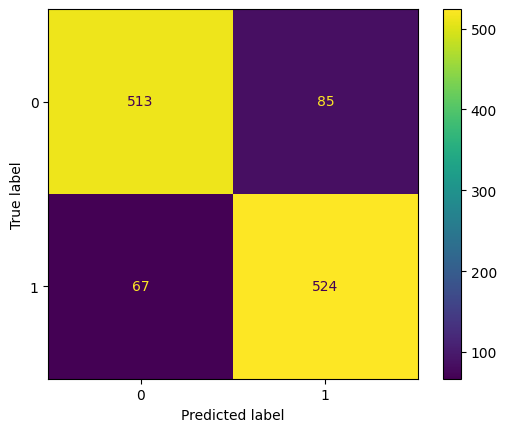

In [ ]:
grid_predictions = best_model.predict(X_test)

count=0
f=[0]*len(grid_predictions)
for value in grid_predictions:
    if value>=0.5:
        f[count]=1
    else:
        f[count]=0
    count+=1


print(classification_report(y_test,f))

cm = confusion_matrix(y_test, f)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


# Análise de resultados e conclusões